<a href="https://colab.research.google.com/github/MarineDelabaere/Projet_ML_UE_AAA/blob/main/ML_Project_UE_D_AAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Utilisation du Machine Learning pour prédire les performances des étudiants en fonction de plusieurs caractéristiques***


Ce projet de Machine Learning s'inscrit dans le cadre de l'UE D AAA (Algorithmes et Apprentissage automatique) proposée par l'école d'ingénieur IMT Atlantique basée à Nantes en France. Il est réalisé par Marine Delabaere, étudiante de cette école.

Ce projet a pour ambition de développer un modèle de machine learning capable de prédire les résultats scolaires en cours de portugais en fonction de plusieurs éléments de la vie sociale d'étudiants portugais (niveau d'études de leurs parents, engagée dans une relation amoureuse ou pas, qualité des relations familiales ...)  de deux établissements scolaires distincts : le lycée Gabriel Pereira et le lycée Mousinho da Silveira.

***I)Téléchargement des librairies et des données***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import IsolationForest, RandomForestRegressor, AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline




In [2]:
student_performance= pd.read_csv("https://raw.githubusercontent.com/MarineDelabaere/Projet_ML_UE_AAA/main/student-por.csv" , sep=";")
target_name = "G3"
data = student_performance.drop(columns=target_name)
target = student_performance[target_name]

In [3]:
numerical_features = ["age", "failures", "absences","G1","G2"]
categorical_features=data.drop(numerical_features, axis=1)

***II)Exploration des données***

In [4]:
student_performance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

Le dataset comporte 649 instances et 33 variables.
Les variables 0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 21 et 22 sont catégorielles. Elles représentent des catégories comme l'établissement scolaire, le sexe, la relation des parents (vivant ensemble ou séparément), le travail des parents, l'accès à Internet etc.
  Toutes les autres sont numériques (l'âge, la consommation d'alcool, le nombre d'absences etc).

  **La target est G3 c'est-à-dire la note (de 0 à 20) obtenu par l'élève en cours de portugais au troisième (et donc dernier) trimestre.**

  Il s'agit donc d'un cas d'apprentissage supervisé plus particulièrement d'un problème de **régression**.

Initialement, il y avait deux datasets : un concernant la performance en mathématiques et l'autre pour la performance en portugais. Ce dernier possédant un peu plus d'instances que le premier, j'ai choisi de l'étudier.

In [5]:
missing_values_count = data.isna().sum()

print(missing_values_count)

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
dtype: int64


Bonne nouvelle : on remarque que l'on n'a **aucune valeur manquante**. Cela va nous épargner du travail dans la partie pré-traitement des données.

Quelques instances du dataset :

In [6]:
student_performance.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


Quelques statistiques basiques sur les données :

In [7]:
student_performance.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


On peut grâce à ces statistiques dresser un premier "portrait robot" de nos individus.

On a affaire à des élèves qui semblent être dans l'équivalent portugais de la classe de Terminale étant donnée la moyenne d'âge de 16,74 ans.

On peut également se rendre compte que le niveau d'éducation de leurs parents est relativement hétérogène bien que correct dans l'ensemble ( la médiane de "Fedu" et "Medu" est de 2 sur une échelle discrète de 0 à 4 tandis que le 3ème quartile est à 4 pour "Medu" et 3 pour "Fedu").

On a également affaire à des élèves qui ont très peu d'échecs à leur actif (la moyenne de "failures", le nombre d'échecs est à 0,22 avec un troisième quartile à 0).

Dans l'ensembles, les élèves ont également de bonnes relations avec leurs parents ( une moyenne de 3,93 et un premier quartile à 4 sur une échelle discrète de 1 à 5 pour la variable "famrel").

Enfin, le niveau des élèves est correct avec des moyennes de G1, G2 et G3 entre 11,40 et 11,91.




***III) Visualisation des données***

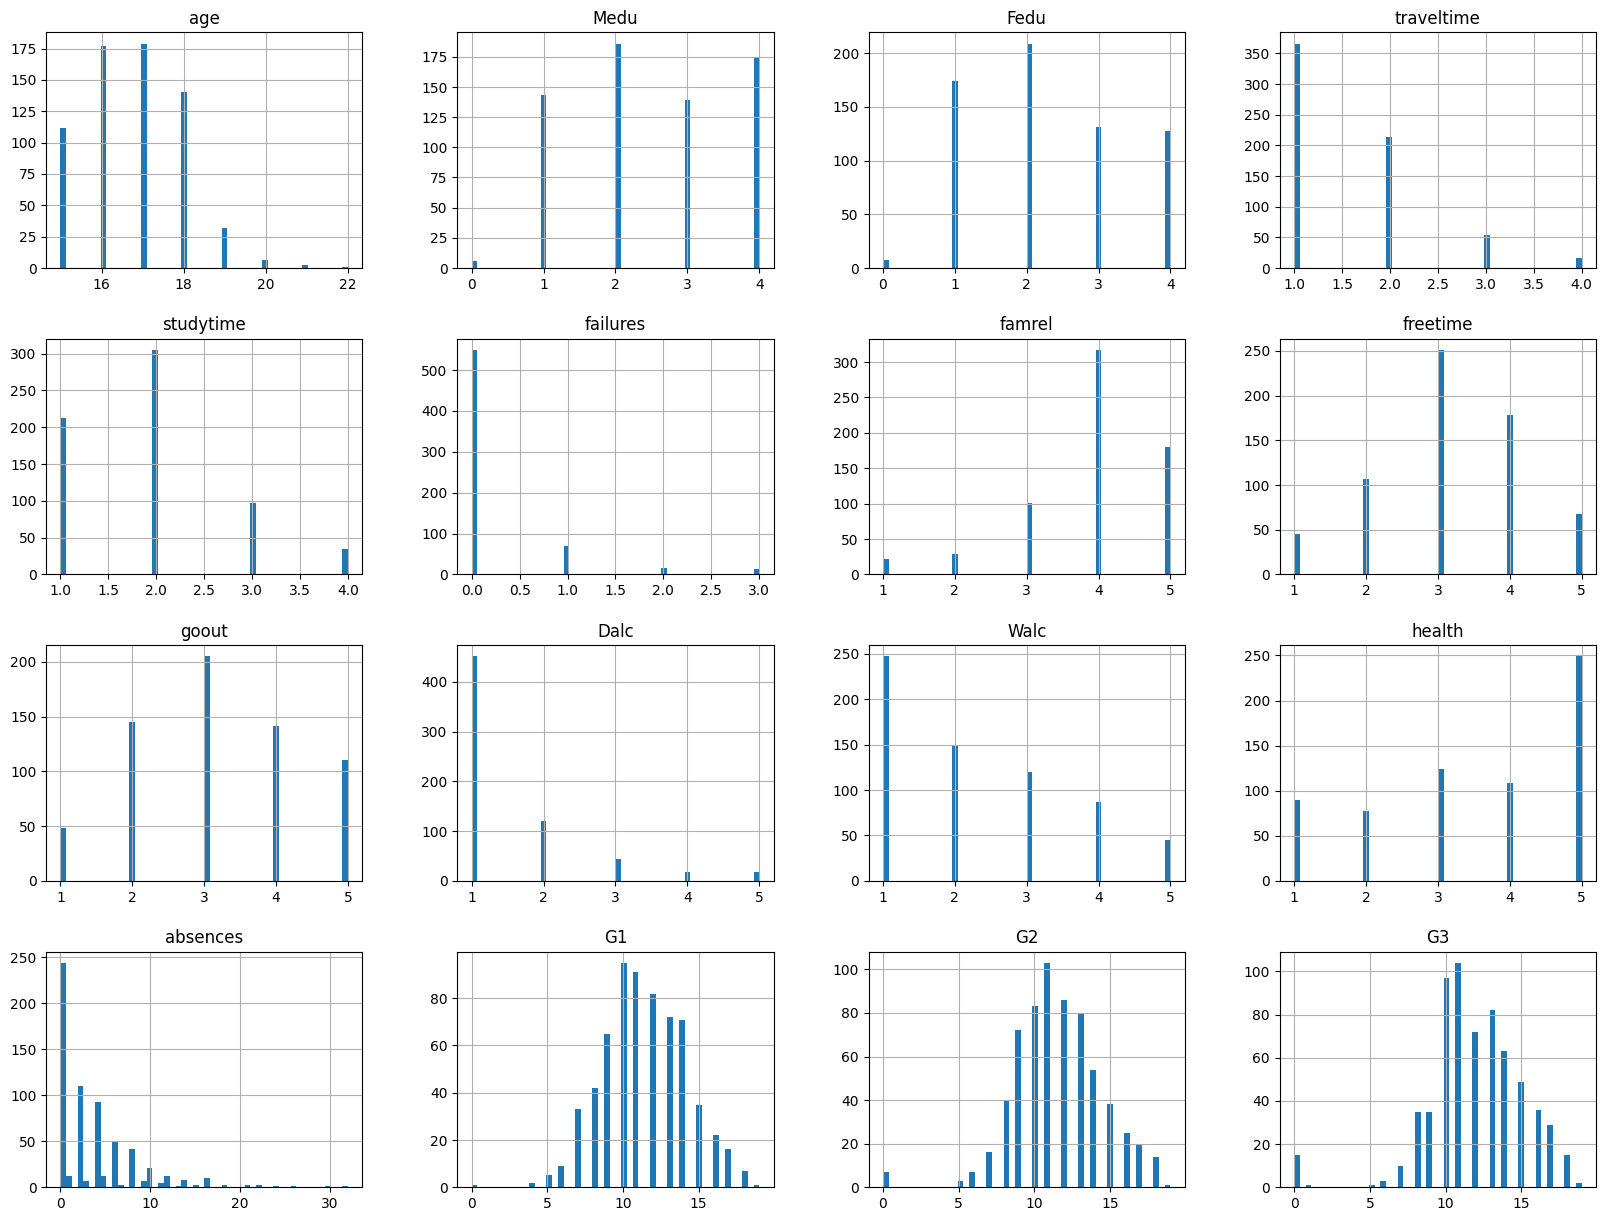

In [8]:
student_performance.hist(bins=50,figsize=(20,15))
plt.show()

Etant donné que nos valeurs numériques sont bornées, on voit assez peu de valeurs aberrantes (outliers). On notera toutefois la quantité significative d'étudiants ayant reçu un 0 alors qu'aucun n'a reçu une note comprise entre 1 et 4. Ce sera intéressant de voir comment notre modèle va gérer ça.

  De plus, il y a quand même une certaine différence d'échelle entre les différentes variables (les valeurs de la catégorie "absences" sont comprises entre 0 et 30, celles de la catégorie "age" de 0 à 22, celles des catégories "G1", "G2" et "G3" de 0 à 20 tandis que les autres sont en gros entre 0 et 5).

  On sera donc probablement amené à devoir normaliser les données.

 Pour avoir une meilleure visualisation de la répartition de nos données, on va représenter nos variables numériques sous forme de BoxPlots et nos variables catégorielles sous forme de CountPlots:

**Variables numériques :**

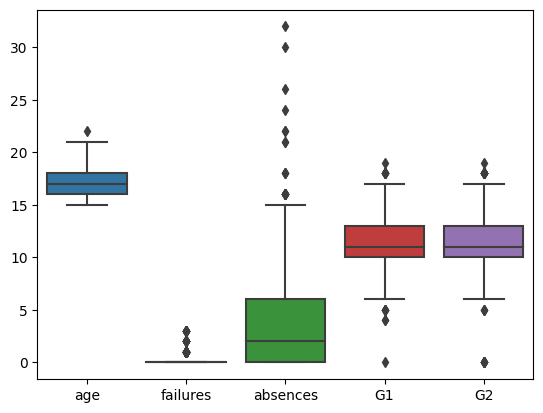

In [9]:
sns.boxplot(data=data[numerical_features], orient="v")
plt.show()

On remarque que dans toutes les catégories numériques, il y a un nombre conséquent de données beaucoup plus faibles que le premier quartile et d'autres beaucoup plus élevées que le troisième quartile (en dehors de la boîte à moustache). Cela montre qu'il y a des outliers dans nos données numériques.

**Variables catégorielles :**

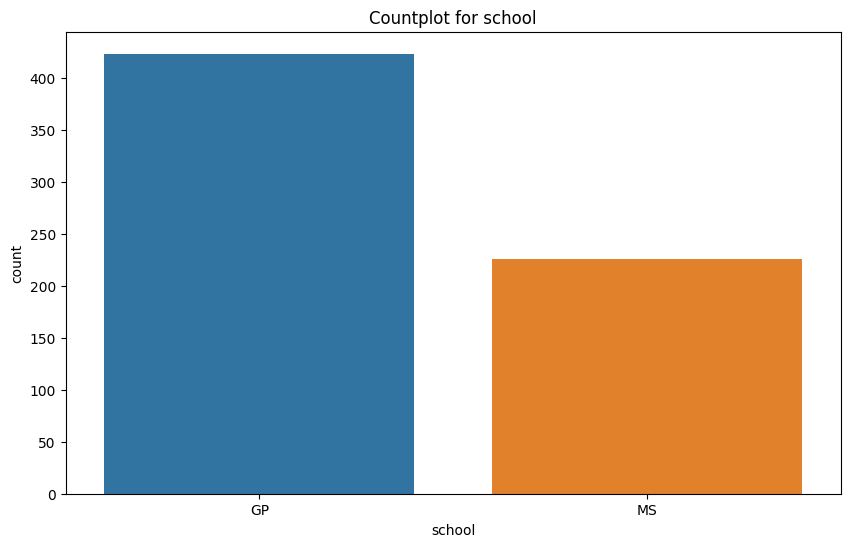

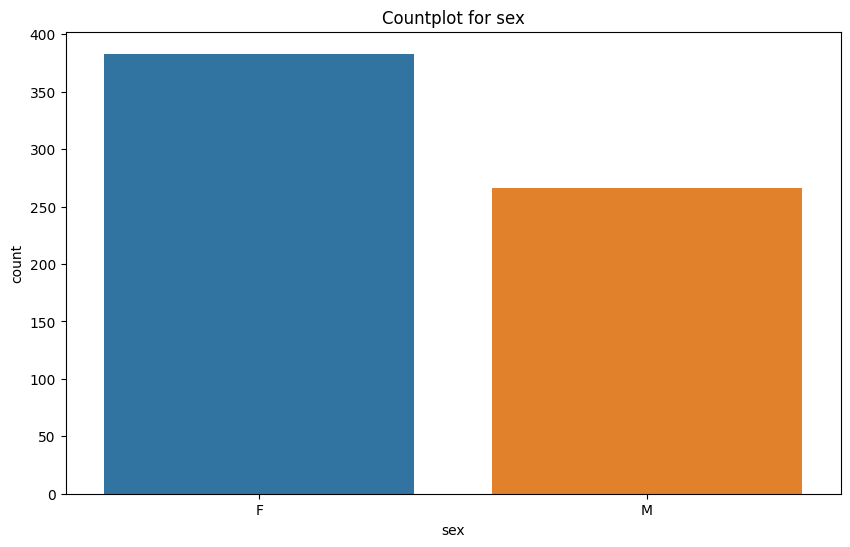

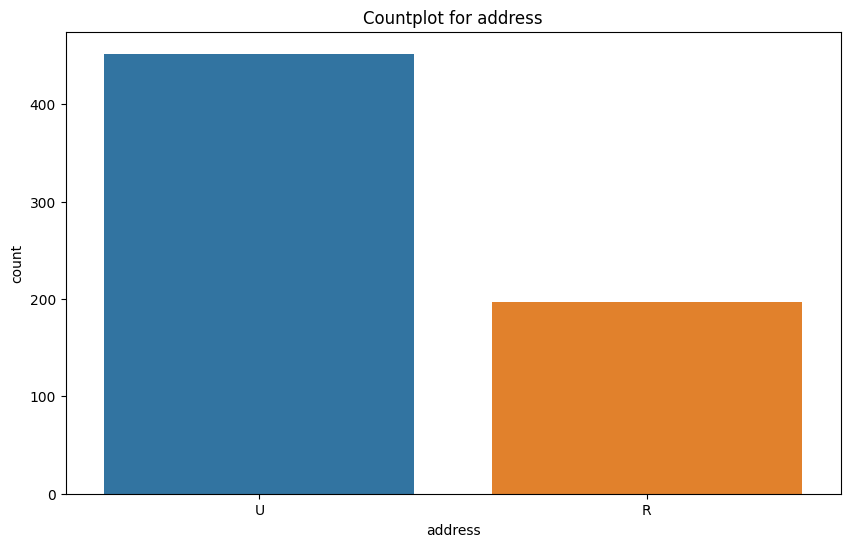

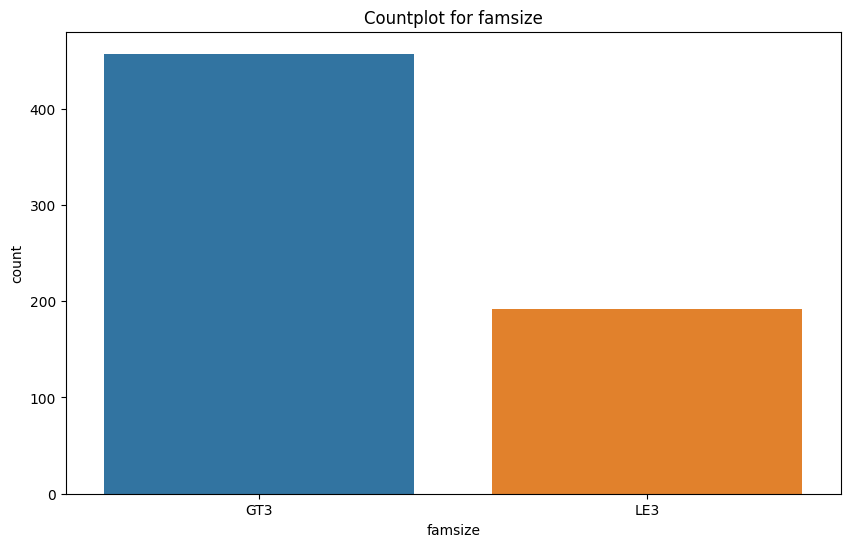

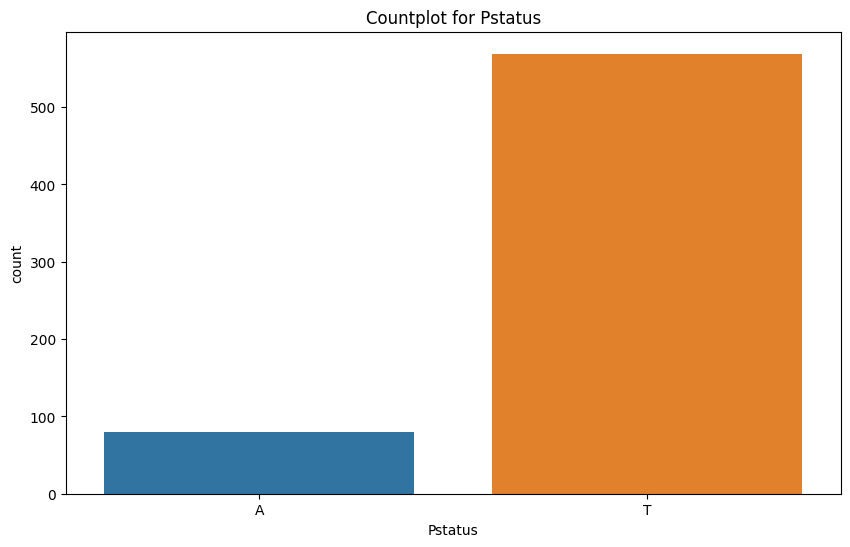

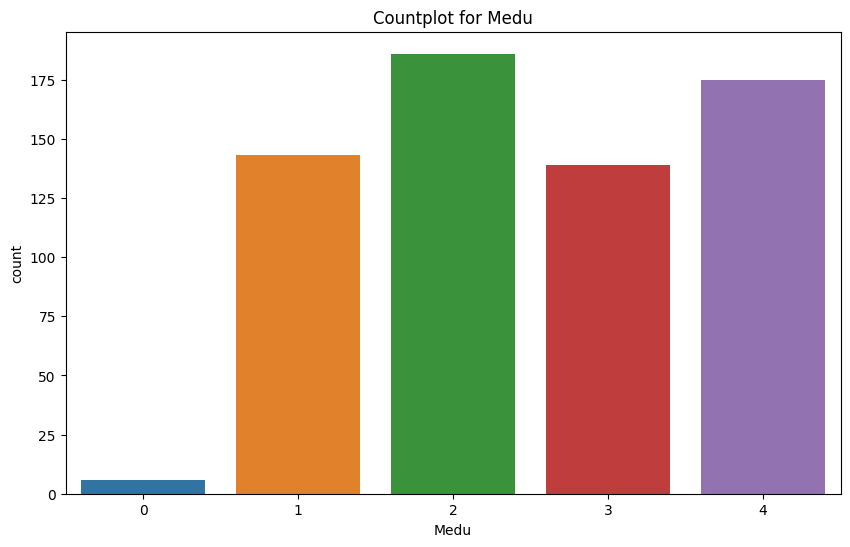

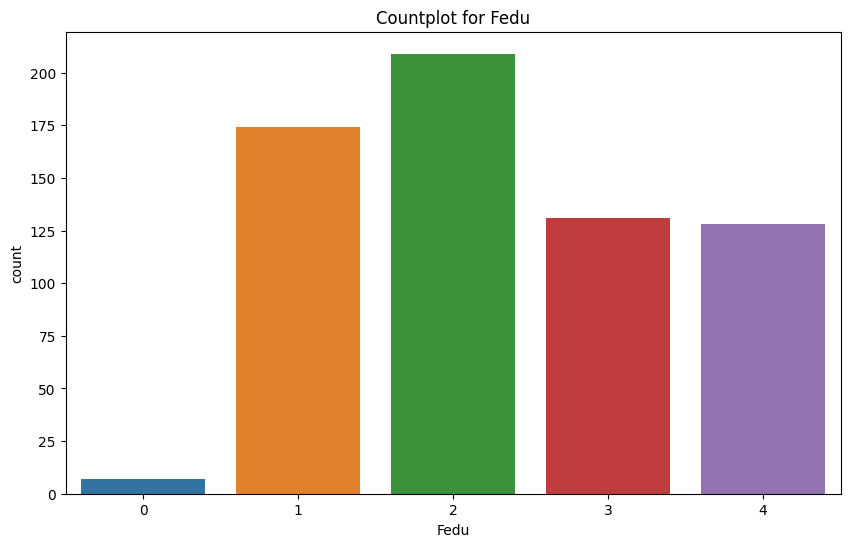

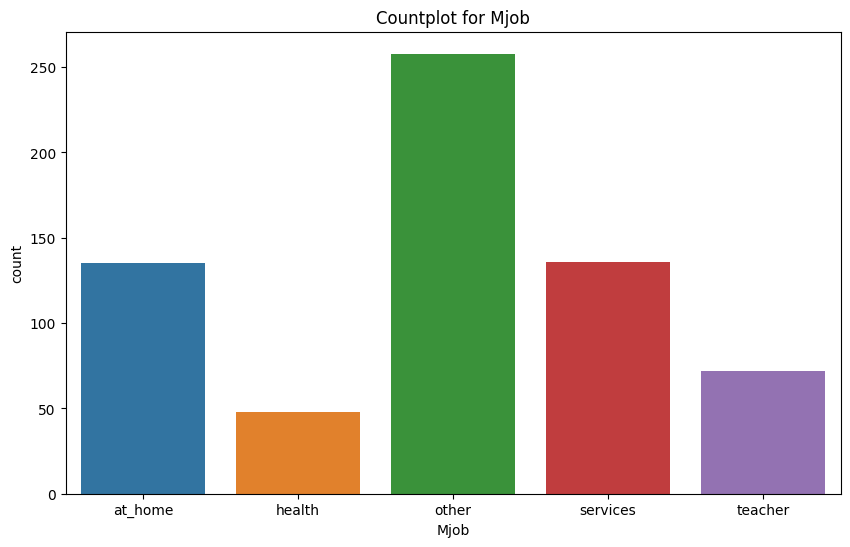

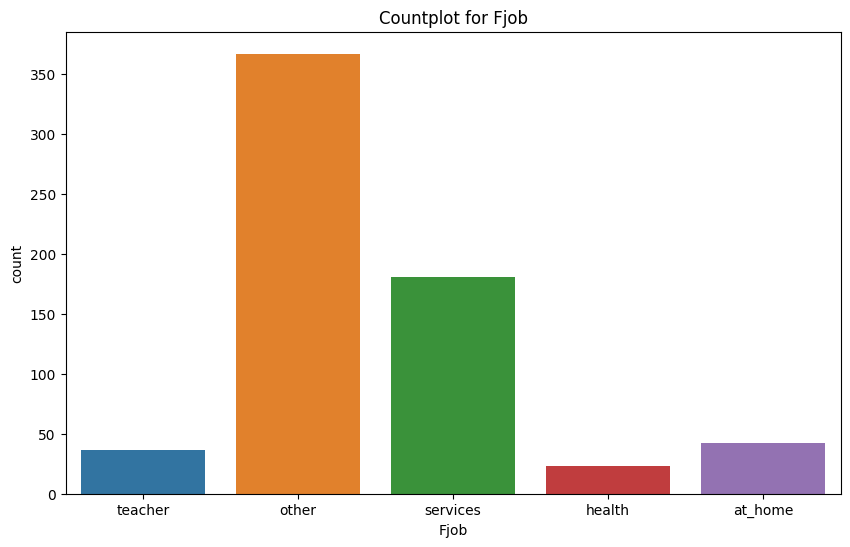

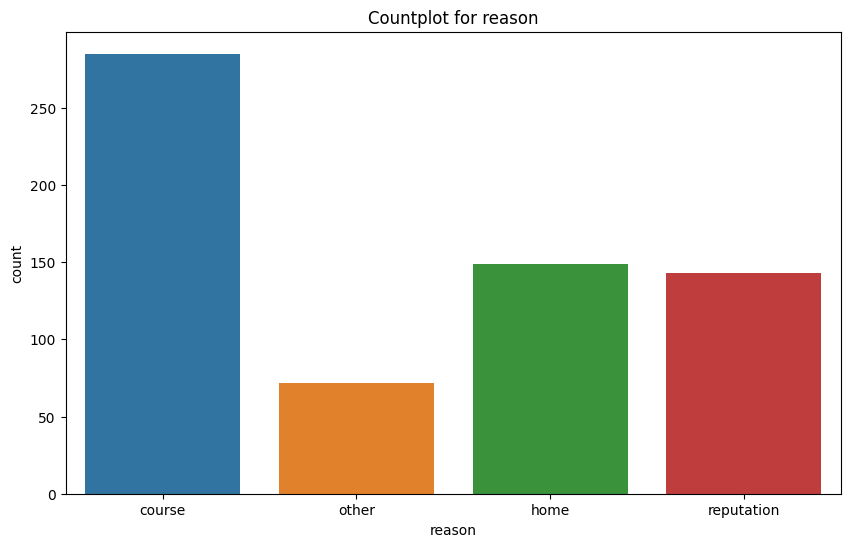

In [ ]:
categorical_columns = categorical_features.columns


for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=categorical_features)
    plt.title(f'Countplot for {column}')
    plt.show()

Tout d'abord, notre dataset manque de précision pour certaines variables. Par exemple, environ 360 échantillons ont leur variable "Fjob" qui vaut "other". Cela va forcément faire diminuer la pertinence de la prédiction de notre modèle.

De plus, beaucoup de nos variables catégorielles ont des classes déséquilibrées. Par exemple : seuls environ 20 élèves se voient payer des cours de soutien en portugais par leurs parents ou bien environ 50 élèves ne veulent pas accéder aux études supérieures .

Cela posera peut-être problème à notre modèle car il aura peu de données de ces classes pour s'entraîner. **D'où la nécessité de stratifier les données au moment de les "spliter".**

In [ ]:

sns.histplot(
    data=student_performance.query("address=='U'or address=='R'"),
    x="G3",
    hue="address",
    stat="density",
    common_norm=False,
);

A première vue, il semble que les élèves qui viennent de zones urbaines ont plus de chance d'avoir une bonne moyenne en portugais au 3ème trimestre que les élèves venant de zones rurales.

In [ ]:
sns.histplot(
    data=student_performance.query("romantic=='yes'or romantic=='no'"),
    x="G3",
    hue="romantic",
    stat="density",
    common_norm=False,
);

On constate que les élèves en échec (moyenne inférieure à 10) ont tendance à être en couple. Pour les notes correctes (entre 11 et 14) il y a une part conséquente d'élèves en couple. Par contre, les bons élèves (plus de 14) ont tendance à être célibataires.

In [ ]:
sns.histplot(
    data=student_performance.query("Fedu==0 or Fedu==1 or Fedu==2 or Fedu==3 or Fedu==4"),
    x="G3",
    hue="Fedu",
    stat="density",
    common_norm=False,
);

Ici, il est nettement plus difficile de déceler des tendances (d'où la nécessité de développer un modèle de machine learning et de ne pas se contenter de visualiser les données avec matplotlib et seaborn).

On peut toutefois noter qu'il semble que parmi les étudiants ayant des notes moyennes (entre 8 et 12) et parmi les étudiants ayant de très bonnes notes (plus de de 16,5) il y a beaucoup d'élèves dont le père n'a pas une très bonne situation professionnelle (catégories 1 et 2). De plus, on remarque que parmi les élèves ayant de bonnes notes (entre 12 et 16) il y a une proportion importante d'élèves dont le père a une bonne situation professionnelle (catégories 3 et 4).

On va à présent utiliser pairplot pour visualiser la relation entre toutes les paires de variables.

In [ ]:
sns.pairplot(data)
plt.show()

On a du mal à vraiment déceler de tendances ou des corrélations avec ce pairplot.

Pour y remédier, va maintenant chercher à mettre en évidence de manière plus précise les corrélations qui existent entre chacune de nos variables et notre target  G3.
Pour cela, on affiche la matrice de corrélation de chacune de nos variables ainsi que la carte de chaleur (heatmap) de ces dernières :

In [ ]:
correlation_matrix=student_performance.corr()
print("Matrice de corrélation :\n", correlation_matrix)

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

On remarque que G1, G2 et G3 sont très fortement corrélées (0,86 entre G1 et G2, 0,83 entre G1 et G3 et 0,92 entre G2 et G3). C'est tout à fait logique. En effet, beaucoup d'élèves qui étaient en échec (respectivement en réussite) aux précédents trimestres seront en échec (respectivement en réussite) au dernier trimestre.

Le fait qu'il y ait une telle corrrélation entre G1, G2 et notre target rend notre projet beaucoup moins utile et pertinent. **On choisit donc de supprimer les variables de notre dataset pour ne garder que les variables purement "sociales".**





In [ ]:
'''data=data.drop(columns="G1")
data=data.drop(columns="G2")'''


Par ailleurs, les autres variables corrélées à la target sont : "studytime" (0,25), "Medu" (0,24), "Fedu" (0,21) qui sont positivement corrélées et "Dalc" (-0,20) et "Walc" (-0,18) qui sont négativement corrélées.

In [ ]:
data.info()

On remarque également que les variables "Fedu" et "Medu" qui représentent respectivement le niveau d'études du père de l'élève et celui de sa mère sont fortement corrélées  (0,65) ce qui signifie que de manière générale les gens ont tendance à se mettre en couple avec des gens ayant le même capital culturel/scolaire qu'eux. De même, les variables "Dalc" et "Walc" qui représentent respectivement la consommation d'alcool en semaine de l'étudiant et sa consommation d'alcool par week-end sont fortement corrélées (0,62) .

**On peut donc légitimement se demander s'il ne serait pas possible de supprimer une des variables du couple ("Fedu", "Medu") et une des variables du couple ("Walc", "Dalc") puisqu'elles semblent redondantes vis-à-vis de l'autre.**

***IV) Pré-traitement et nettoyage des données***

Cette réflexion introduit parfaitement notre prochaine étape : le nettoyage et le pré-traitement (pre-processing) des données.

On choisit d'abord de séparer notre dataset en un train set (80% du dataset) et un test set (20% du dataset).

In [ ]:
X,y=data,target

In [ ]:
y.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_test.value_counts()

In [ ]:
X_train

On remarque que la proportion des différentes classes de G3 n'est pas exactement la même dans y_test que dans y (par exemple la classe 12 représente 11% des valeurs alors qu'elle ne représente que 7% des
valeurs de y_test).

On pourrait penser que le fait d'imposer **une stratification empêcherait ce genre de souci**. Le problème c'est que lorsque l'on tente de stratifier on reçoit un message d'erreur car certaines de nos classes ne comportent qu'un élément, cette classe sera donc forcément absente soit de y_train soit de y_test.

**Cela illustre une faiblesse intrinsèque de notre dataset : il possède un nombre d'instances (649) un peu faible.**

N'ayant pas le choix, on va continuer le projet sans stratifier le train set et le test set en espérant que cela n'ait pas trop d'impact négatif sur les performances de notre modèle.





On va maintenant normaliser nos données afin de faciliter le travail de notre modèle (cela évite qu'une variable prenne plus d'"importance" que d'autres lors de l'exécution de notre algorithme).
On choisit d'utiliser StandardScaler (plutôt que MinMaxScaler ou RobustScaler par exemple) car c'est un scaler plus adapté au PCA.

In [ ]:
new_numerical_features = ["age", "failures", "absences","G1","G2"]



scaler = StandardScaler()
X_train[new_numerical_features] = scaler.fit_transform(X_train[new_numerical_features])
X_test[new_numerical_features] = scaler.transform(X_test[new_numerical_features])


In [ ]:
X_test.head()


Maintenant, on encode les variables catégorielles au moyen de get_dummies et pas de OneHotEncoder (mais cela revient sensiblement au même) car cela provoquait l'apparition de valeurs manquantes (je n'arrive pas à expliquer cela mais l'essentiel est que le problème soit résolu) :

In [ ]:
X_train = pd.concat([X_train[new_numerical_features],
                     pd.get_dummies(X_train.school),
                     pd.get_dummies(X_train.sex),
                     pd.get_dummies(X_train.address),
                     pd.get_dummies(X_train.famsize),
                     pd.get_dummies(X_train.Pstatus),
                     pd.get_dummies(X_train.Mjob),
                     pd.get_dummies(X_train.Fjob),
                     pd.get_dummies(X_train.reason),
                     pd.get_dummies(X_train.guardian),
                     pd.get_dummies(X_train.schoolsup),
                     pd.get_dummies(X_train.famsup),
                     pd.get_dummies(X_train.paid),
                     pd.get_dummies(X_train.activities),
                     pd.get_dummies(X_train.nursery),
                     pd.get_dummies(X_train.higher),
                     pd.get_dummies(X_train.internet),
                     pd.get_dummies(X_train.romantic)], axis=1)

X_test = pd.concat([X_test[new_numerical_features],
                     pd.get_dummies(X_test.school),
                     pd.get_dummies(X_test.sex),
                     pd.get_dummies(X_test.address),
                     pd.get_dummies(X_test.famsize),
                     pd.get_dummies(X_test.Pstatus),
                     pd.get_dummies(X_test.Mjob),
                     pd.get_dummies(X_test.Fjob),
                     pd.get_dummies(X_test.reason),
                     pd.get_dummies(X_test.guardian),
                     pd.get_dummies(X_test.schoolsup),
                     pd.get_dummies(X_test.famsup),
                     pd.get_dummies(X_test.paid),
                     pd.get_dummies(X_test.activities),
                     pd.get_dummies(X_test.nursery),
                     pd.get_dummies(X_test.higher),
                     pd.get_dummies(X_test.internet),
                     pd.get_dummies(X_test.romantic)], axis=1)


In [ ]:
missing_values_count = X_train.isna().sum()

# Afficher le résultat
print(missing_values_count)

In [ ]:
missing_values_count = X_test.isna().sum()

# Afficher le résultat
print(missing_values_count)

In [ ]:
X = pd.concat([X_train, X_test])

Nos données ont été standardisées et encodées avec succès.

On va maintenant éliminer les anomalies qu'il pourrait y avoir dans notre dataset avec l'algorithme d'Isolation Forest.

On choisit  arbitrairement un taux de contamination (c'est-à-dire le pourcentage d'échantillons aberrants que l'on souhaite éliminer  du dataset) de 1%.


In [ ]:
isolation_forest = IsolationForest(contamination=0.1)


isolation_forest.fit(X)

y_pred_IF = isolation_forest.predict(X)

In [ ]:
anomalies = X[y_pred_IF == -1]

#Affichage du nombre d'anomalies détectées
print(f"Nombre d'anomalies détectées : {len(anomalies)}")

# Affichage des indices des anomalies
print("Indices des anomalies :")
print(anomalies.index)

On ne conserve dans le data set que les valeurs non aberrantes.

In [ ]:
X=X[y_pred_IF==1]

Pour finir, on applique le PCA (Analyse en parties principales) afin de réduire la dimension du dataset (et ainsi indirectement éliminer les variables "inutiles" car doublons comme dans le cas évoqué précédemment de "Dalc"-"Walc" et "Fedu"-"Medu"). Cela nous permettra également d'éviter l'overfitting tout en conservant un maximum de variance dans notre dataset.

In [ ]:
X.shape

On a de nouveau ce problème de valeurs manquantes. On va de nouveau appliquer un imputer qui remplacera les valeurs manquantes par la moyenne. On standardise ensuite pour bien pouvoir appliquer le PCA. On choisit de faire un premier PCA à 46 variables pour démarrer avant de chercher le nombre de composants minimal qui assure une bonne variance.

In [ ]:
model_PCA = PCA(n_components=46)
X_reduced= model_PCA.fit_transform(X)


On affiche le taux de variance (de 0 à 1) des données en fonction du nombre de composants choisi pour faire le PCA.

In [ ]:
plt.plot(np.cumsum(model_PCA.explained_variance_ratio_))

On choisit de conserver 99% de la variance de nos données. En appliquant la fonction argmax de numpy, on peut déterminer quel est le nombre de composants minimal pour conserver 99% de la variance.

In [ ]:
np.argmax(np.cumsum(model_PCA.explained_variance_ratio_)>0.99)

On applique donc le PCA avec un nombre de composants égal à 26.

In [ ]:
model_PCA = PCA(n_components=26)
X = model_PCA.fit_transform(X)

**V) Développement du modèle**



**1.Choix du modèle**

On passe maintenant à la partie de développement de notre modèle de machine learning.

On va évaluer différents modèles de machine learning pertinents pour résoudre un problème de régression : une LinearRegression, une méthode de Lasso, une RandomForest et un AdaBoost.
De plus, on décide de rajouter un preprocesseur qui rajoute à nos données des caractéristiques supplémentaires à savoir le carré de toutes les caractéristiques déjà existantes.
Ceci dit, nous n'avons pu appliquer ce preprocesseur qu'aux modèles non linéaires (RandomForest et AdaBoost) car dans le cas des modèles linéaires (LinearRegression et Lasso), cela posait des problèmes d'allocation de mémoire.

In [ ]:
preprocessor=make_pipeline(PolynomialFeatures(2))

In [ ]:
LinR=LinearRegression()
Lasso_model=Lasso()
RandomForest=make_pipeline(preprocessor, RandomForestRegressor(random_state=1))
AdaBoost=make_pipeline(preprocessor, AdaBoostRegressor(random_state=1))

In [ ]:
list_of_models=[LinR, Lasso_model, RandomForest,AdaBoost]

On créé une fonction d'évaluation qui permet d'afficher les courbes d'apprentissage (learning curves) de chacun de nos modèles afin de déterminer celui que l'on va sélectionner (le plus efficient).
On transforme également nos données qui étaient des DataFrames en tableaux numpy afin de pouvoir appliquer les méthodes présentes dans notre fonction d'évaluation.

In [ ]:
y_train = np.array(y_train)
X_train=np.array(X_train)
y_test = np.array(y_test)
X_test=np.array(X_test)

In [ ]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    N, train_score, val_score = learning_curve(
        model, X_train, y_train, cv=4, scoring='neg_mean_squared_error'
    )

    # Convertir les scores en valeurs positives
    train_score = -train_score
    val_score = -val_score

    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='validation_score')
    plt.legend()


In [ ]:
for model in list_of_models:
  evaluation(model)

Analysons les performances de nos 4 modèles :

-Régression linéaire : la courbe du train score et celle du validation score convergent vers une erreur d'environ 7,5. On a une performance correcte et pas d'overfitting.

-Lasso : ce modèle n'overfit pas puisque le train score augmente beaucoup au début. Les performances sont moins bonnes que pour la LinearRegression et les courbes de train_score et validation_score semblent diverger au final.

-RandomForest : performances similaires à la LinearRegression mais semble overfitter.

-AdaBoost : valeur de validation score similaire à la LinearRegression et la RandomForest mais un train score plutôt bas mais qui semble petit à petit converger vers le train_score (donc a priori pas trop d'overfit)


**On choisit de conserver le modèle d'AdaBoost** qui avec la LinearRegression semble offrir les meilleures performances sans trop d'overfit. AdaBoost a été préféré à LinearRegression de par le fait qu'il combine les résultats de plusieurs modèles simples entraînés simultanément.

**2.Optimisation du modèle**

On va optimiser les hyperparamètres de notre modèle d'AdaBoost.

In [ ]:
hyper_params={'adaboostregressor__n_estimators':[50, 100, 200],
              'adaboostregressor__learning_rate':[0.001,0.01, 0.1],
              'adaboostregressor__loss':['linear','square','exponential'],
              'pipeline__polynomialfeatures__degree':[1,2]
              }


On utilise un RandomizedSearchCV plutôt qu'un GridSearchCV pour la recherche d'hyperparamètres optimaux car le nombre d'hyperparamètres d'un AdaBoost est particulièrement et tester toutes leurs combinaisons possibles prendrait un temps énorme à l'ordinateur.
RandomizedSearchCV va tester 30 combinaisons possibles d'hyperparamètres et nous renvoyer la meilleure des 30.

In [ ]:
grid=RandomizedSearchCV(AdaBoost,hyper_params,scoring='neg_mean_squared_error', cv=4, n_iter=30)
grid.fit(X_train, y_train)
print(grid.best_params_)
y_pred_after_optim=grid.predict(X_test)
print(y_pred_after_optim)

In [ ]:
y_test

In [ ]:
AdaBoost=make_pipeline(preprocessor, AdaBoostRegressor(random_state=1,n_estimators=50, loss='square',learning_rate=0.001))

In [ ]:
evaluation(AdaBoost)

On constate que les performances du modèle sont peu satisfaisantes (la courbe d'apprentissage est quasiment identique avant et après optimisation des hyperparamètres) en particulier sur des valeurs extrêmes (en dessous de 8 et au dessus de 14). Il n'arrive jamais à descendre aussi bas ou à monter aussi haut. On peut supposer que comme pressenti, la taille de notre dataset est un peu faible pour pour que notre modèle réalise des prédictions de qualité. Notre modèle n'a certainement pas assez vu de valeurs "extrêmes" durant sa phase d'entraînement

Toutefois, on se rappelle que nous avions délibérément choisi de retirer les variables G1 et G2 de notre dataset avant le pré-traitement des données car nous voulions développer un modèle qui prédit la moyenne des élèves en portugais au 3ème trimestre en se basant uniquement sur des caractéristiques sociales des élèves. Or, ces dernières étaient grandement corrélées à notre target G3.

Voici les résultats que l'on obtient en commentant la ligne :

data=data.drop(columns="G1")


data=data.drop(columns="G2") :

{'pipeline__polynomialfeatures__degree': 2, 'adaboostregressor__n_estimators': 200, 'adaboostregressor__loss': 'exponential', 'adaboostregressor__learning_rate': 0.01}


[ 7.4137931  10.8627451   8.97222222  7.41935484 10.98125    10.98125
 15.11594203 12.96747967 15.275      14.63636364  9.30909091 10.86144578
 13.0130719  12.96478873 16.83333333 12.95419847  9.10958904  9.32653061
 13.         10.92356688 15.25454545  6.71428571  8.78861789  9.46428571
 10.97826087  9.31683168 10.91596639 12.96240602 12.96899225 10.85611511
  9.46987952 12.95774648 10.88819876  7.45714286  9.36170213 10.97826087
 12.96899225 15.22666667 17.02857143 15.22666667 16.86842105 10.98192771
 12.96899225 13.         10.98192771 17.02083333 14.78571429 17.
 10.85611511 15.14925373 10.73134328 17.02631579 10.97826087 15.875
 17.         10.88535032  8.66981132 10.88819876 13.         14.71428571
 10.86144578  9.32653061 15.22666667 10.97126437 17.         12.95967742
 15.19753086 17.         10.87647059 15.22666667 13.         16.84210526
 10.8627451  10.97826087 10.97333333 14.48648649 16.80952381  9.30588235
 12.976      10.8627451  10.97826087 12.95614035 13.         17.
  8.71551724 15.275      12.95774648 12.96747967 10.88535032 16.8
 16.85714286 12.96240602  9.37142857 11.         15.11594203 15.22666667
 12.96774194 10.97333333  9.66216216  8.31818182  8.66363636 10.88976378
 13.00775194 12.96551724 12.95774648  8.60576923 10.97826087 12.96747967
 12.99180328 13.         10.85380117  9.07777778 15.22666667 13.
  7.89361702 15.11594203 12.95774648 17.         10.88976378 10.8627451
 13.02173913 10.73134328 14.93939394  9.47826087  9.74675325 12.96478873
 10.97333333  1.41176471  9.58974359  7.8125    ]

On voit (comme prévu) que le modèle est beaucoup plus performant lorsque l'on ne supprime pas les variables G1 et G2 du dataset. Ce que confirme sa courbe d'apprentissage :

In [ ]:
from IPython.display import Image


image_url = 'https://github.com/MarineDelabaere/Projet_ML_UE_AAA/blob/main/courbe_apprentissage_ada_boost_T1_2.png'


Image(url=image_url)